## 多參數時間序列預測

### 讀取資料

In [1]:
from pandas import read_csv
from datetime import datetime

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 資料預處理

In [2]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### 探索資料

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


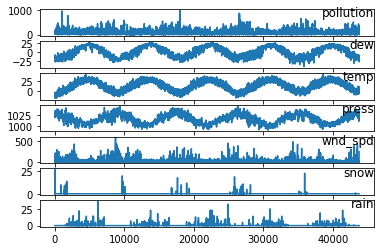

In [3]:
%pylab inline
from matplotlib import pyplot
values = dataset.values

groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### 資料編碼

In [4]:

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')

In [8]:
dataset.head(3)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0


In [7]:
values[0:3]

array([[ 129.  ,  -16.  ,   -4.  , 1020.  ,    2.  ,    1.79,    0.  ,
           0.  ],
       [ 148.  ,  -15.  ,   -4.  , 1020.  ,    2.  ,    2.68,    0.  ,
           0.  ],
       [ 159.  ,  -11.  ,   -5.  , 1021.  ,    2.  ,    3.57,    0.  ,
           0.  ]], dtype=float32)

### 資料轉換

In [9]:
import pandas
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### 正規化特徵

In [11]:
from sklearn.preprocessing import MinMaxScaler
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [13]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


### 捨棄掉不需要預測的欄位

In [14]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head(3)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.0,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.0,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.0,0.0,0.182093


### 分為訓練與測試資料集

In [15]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X , test_y  = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))

### 建立模型

In [16]:
import keras
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

Using TensorFlow backend.
W0907 10:54:21.425041  6008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 10:54:21.441042  6008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 10:54:21.444042  6008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 10:54:21.614052  6008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


### 訓練模型

In [17]:
history = model.fit(train_X, train_y, epochs=50, 
                    batch_size=72, validation_data=(test_X, test_y), 
                    verbose=0, shuffle=False)

W0907 10:54:34.165770  6008 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0907 10:54:34.610795  6008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0907 10:54:34.672799  6008 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



### 繪製損失圖

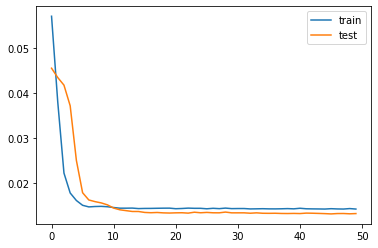

In [18]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 產生預測

In [19]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [20]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### 計算RMSE

In [21]:
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.412


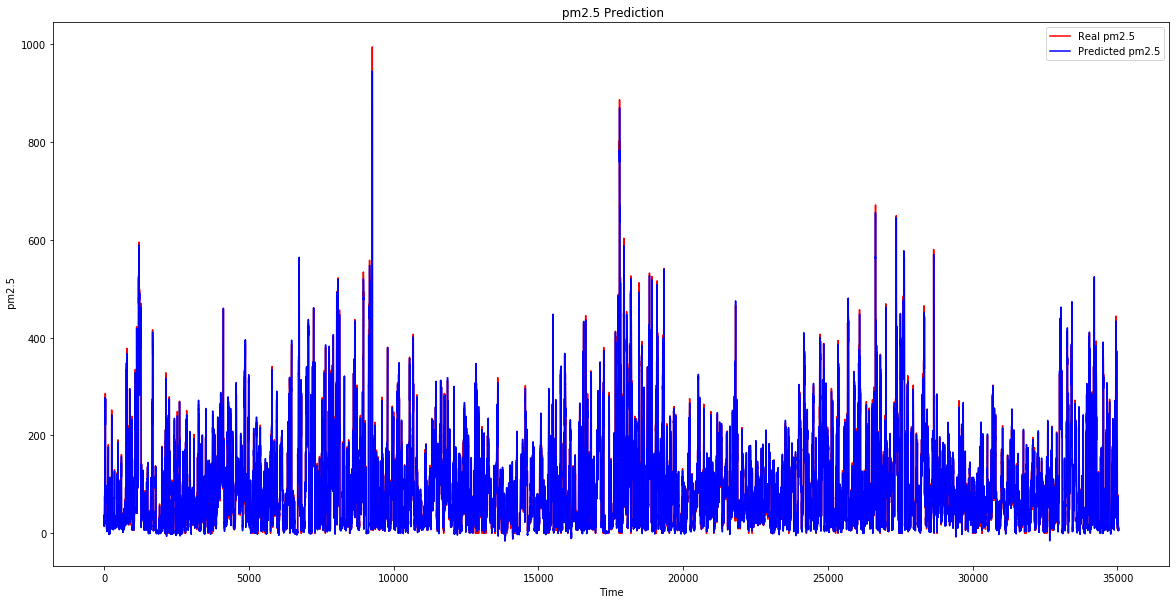

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(inv_y, color = 'red', label = 'Real pm2.5')
plt.plot(inv_yhat, color = 'blue', label = 'Predicted pm2.5')
plt.title(' pm2.5 Prediction')
plt.xlabel('Time')
plt.ylabel(' pm2.5')
plt.legend()
plt.show()

In [31]:

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

x = np.array([2,10])
sigmoid_function(x)

array([0.88079708, 0.9999546 ])

## 降低維度

In [32]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.data.shape

(150, 4)

In [36]:
from sklearn.decomposition import PCA
clf = PCA(n_components=2)
X = clf.fit_transform(iris.data)

In [41]:
clf.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

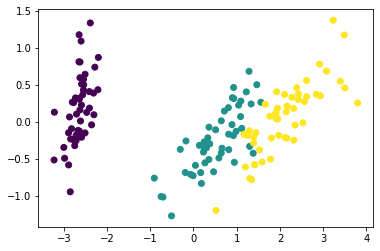

In [40]:
from matplotlib import pyplot as plt
plt.scatter(X[:,0],X[:,1], c= iris.target)
plt.show()

## 利用自編碼網路重建影像

In [42]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [43]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [44]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [45]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [46]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### 讀取MNIST數據

In [47]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [48]:
x_train= x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255.
x_train= x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### 訓練模型

In [49]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.3606 - val_loss: 0.2706
Epoch 2/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.2622 - val_loss: 0.2501
Epoch 3/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.2398 - val_loss: 0.2278
Epoch 4/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.2208 - val_loss: 0.2115
Epoch 5/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.2066 - val_loss: 0.1993
Epoch 6/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.1958 - val_loss: 0.1898
Epoch 7/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1874 - val_loss: 0.1823
Epoch 8/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1806 - val_loss: 0.1760
Epoch 9/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.1748 - val_loss: 0.1706
Epoch

### 檢視編碼與重建數據

In [51]:
autoencoder.get_weights()[0].shape

(784, 32)

In [52]:
autoencoder.get_weights()[1].shape

(32,)

In [53]:
autoencoder.get_weights()[2].shape

(32, 784)

In [55]:
x_test.shape

(10000, 784)

In [54]:
encoded_imgs = encoder.predict(x_test)
encoded_imgs.shape

(10000, 32)

In [56]:
32 / 784

0.04081632653061224

In [57]:
784 / 32

24.5

In [58]:
decoded_imgs = decoder.predict(encoded_imgs)

In [59]:
decoded_imgs.shape

(10000, 784)

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


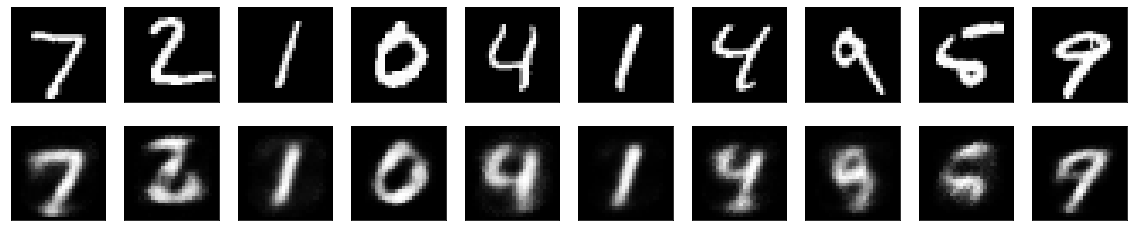

In [60]:
%pylab inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 信用卡詐欺預測
- https://www.kaggle.com/mlg-ulb/creditcardfraud

### 引用套件

In [61]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%pylab inline

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Populating the interactive namespace from numpy and matplotlib


### 讀取資料

In [62]:
df = pd.read_csv("creditcard.csv")

In [63]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 資料探索 (Exploratory Data Analysis)

In [66]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [67]:
284315 / (284315 + 492)

0.9982725143693799

Text(0, 0.5, 'Frequency')

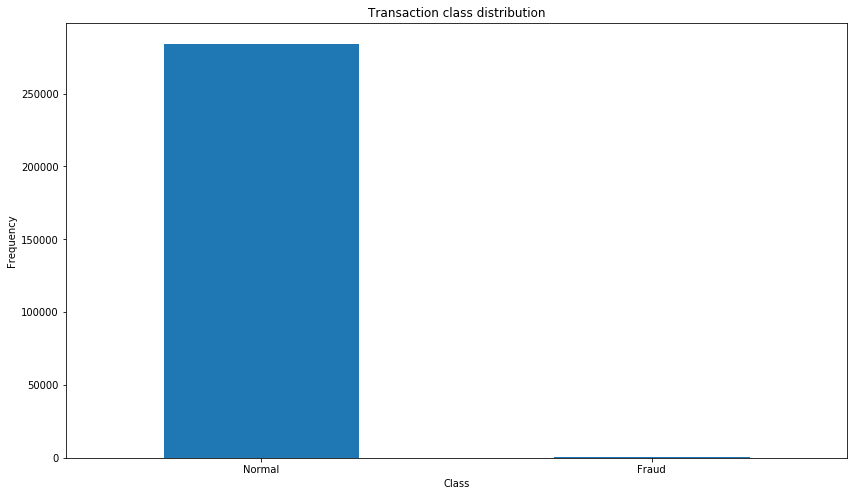

In [69]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [70]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

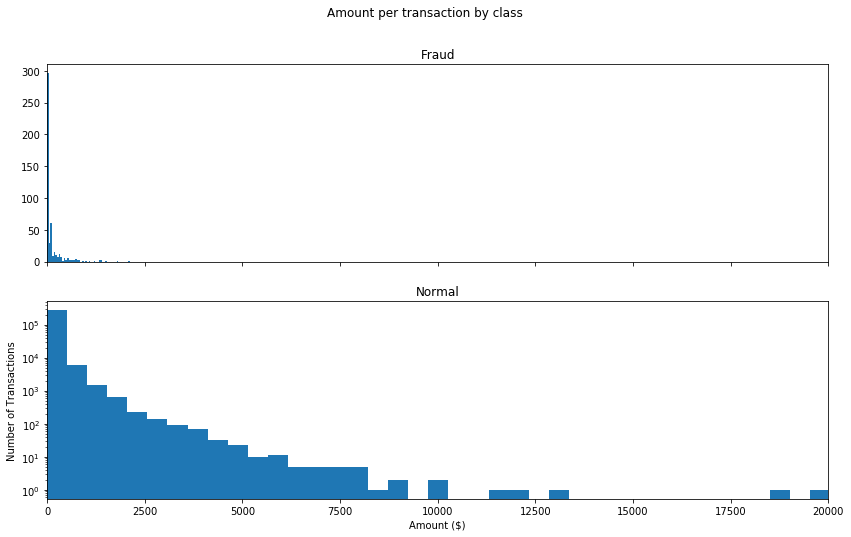

In [71]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

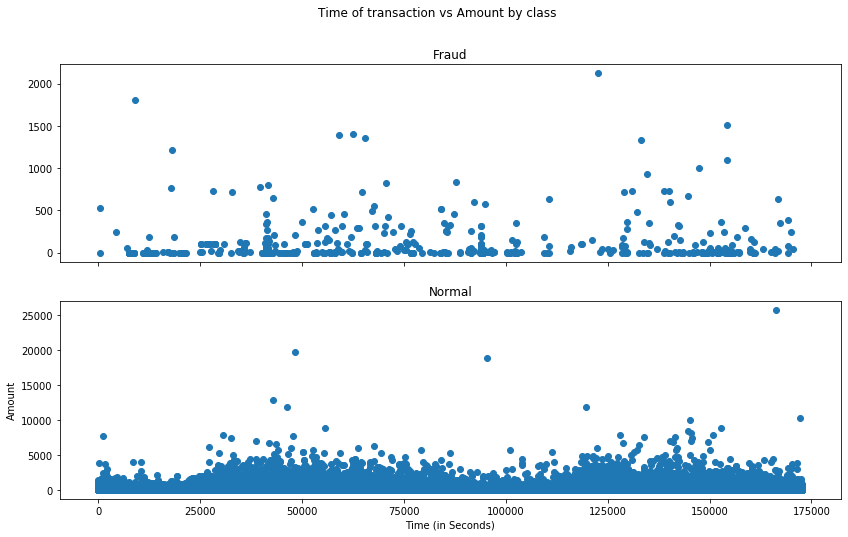

In [72]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### 標準化資料

In [74]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

sc = StandardScaler()
data['Amount'] = sc.fit_transform(data['Amount'].values.reshape(-1, 1))

In [75]:
data.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0


### 將資料分為訓練與測試資料集

In [76]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

### 建立 Auto Encoders

In [79]:
input_dim = X_train.shape[1]
input_dim

29

In [80]:
encoding_dim = 14

In [81]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(7, activation="relu")(encoder)

decoder = Dense(7, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [82]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_7 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


In [83]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 6s 24us/step - loss: 0.8042 - acc: 0.6010 - val_loss: 0.7843 - val_acc: 0.6477
Epoch 2/10
227451/227451 [==============================] - 5s 23us/step - loss: 0.7449 - acc: 0.6443 - val_loss: 0.7718 - val_acc: 0.6511
Epoch 3/10
227451/227451 [==============================] - 5s 23us/step - loss: 0.7369 - acc: 0.6520 - val_loss: 0.7673 - val_acc: 0.6590
Epoch 4/10
227451/227451 [==============================] - 5s 23us/step - loss: 0.7327 - acc: 0.6589 - val_loss: 0.7655 - val_acc: 0.6569
Epoch 5/10
227451/227451 [==============================] - 5s 23us/step - loss: 0.7300 - acc: 0.6643 - val_loss: 0.7614 - val_acc: 0.6693
Epoch 6/10
227451/227451 [==============================] - 5s 23us/step - loss: 0.7281 - acc: 0.6695 - val_loss: 0.7603 - val_acc: 0.6734
Epoch 7/10
227451/227451 [==============================] - 5s 23us/step - loss: 0.7266 - acc: 0.6792 - val_loss: 0

### 模型評估

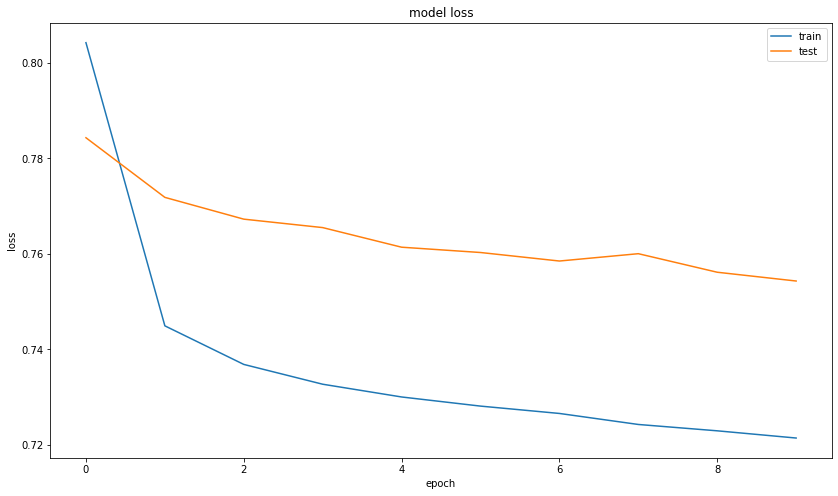

In [84]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [85]:
predictions = autoencoder.predict(X_test)

In [86]:
predictions.shape

(56962, 29)

In [87]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [89]:
error_df.head()

,reconstruction_error,true_class
43428,82.164807,1
49906,0.858804,0
29474,0.290896,0
276481,0.368372,0
278846,0.170501,0


In [90]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

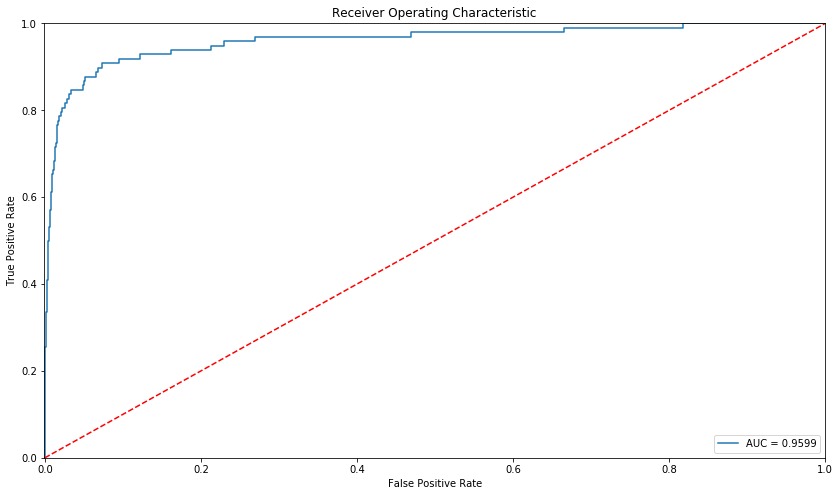

In [91]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 找尋最佳切點

In [92]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame(
    {'fpr'   : pd.Series(fpr, index=i),
     'tpr'   : pd.Series(tpr, index = i), 
     '1-fpr' : pd.Series(1-fpr, index = i), 
     'tf'    : pd.Series(tpr - (1-fpr), index = i), 
     'thresholds' : pd.Series(thresholds, index = i)})

In [93]:
roc.head()

,fpr,tpr,1-fpr,tf,thresholds
0,0.000000,0.000000,1.000000,-1.000000,260.182525
1,0.000000,0.010204,1.000000,-0.989796,259.182525
2,0.000000,0.020408,1.000000,-0.979592,198.226057
3,0.000035,0.020408,0.999965,-0.979557,157.304444
4,0.000035,0.030612,0.999965,-0.969353,154.269776


In [95]:
roc.loc[(roc.tf-0).abs().argsort()[0]]

fpr           0.092466
tpr           0.908163
1-fpr         0.907534
tf            0.000630
thresholds    1.035376
Name: 175, dtype: float64

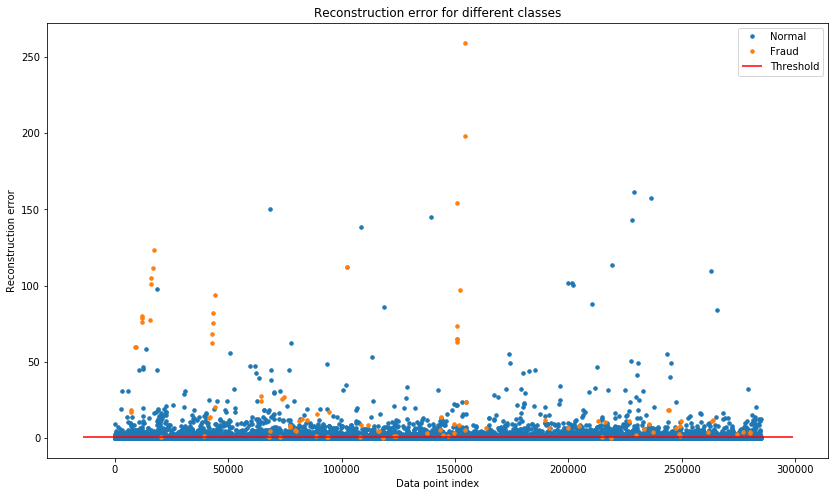

In [96]:
threshold = 1.031592
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [98]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
#y_pred

In [99]:
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
conf_matrix

array([[51571,  5293],
       [    9,    89]], dtype=int64)